# Examples using Lorentzian model 

The objective of this notebook is to show how to use one of the models of 
the [QENSlibrary](https://github.com/QENSlibrary/QENSmodels) to perform some 
fits.

Two different modules will be used for fitting:
- `scipy.optimize.curve_fit`
- `lmfit`

In [1]:
# import python modules for plotting, fitting
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
# for interactive plot
import ipywidgets

# import model from QENS library
import QENSmodels

The figure below illustrates this symmetric peak shape function with ScaleFactor=1, PeakCentre=0 and FWHM=0.5:

In [2]:
xx = np.linspace(-5,5,100)

def interactive_plot(scale_factor, peak_centre, fwhm):
    plt.plot(xx, QENSmodels.lorentzian(xx, float(scale_factor), float(peak_centre), float(fwhm)))
    
    plt.ylabel('lorentzian(x,{scale_factor},{peak_centre},{fwhm})'.
               format(scale_factor=scale_factor, peak_centre=peak_centre, fwhm=fwhm))

    plt.xlabel('x')
    plt.grid()
    plt.show()

interactive_plot = ipywidgets.interactive(interactive_plot, scale_factor=(1,10), peak_centre=(0, 10), fwhm=(1,5))
output = interactive_plot.children[-1]
output.layout.height = '270px'
interactive_plot

interactive(children=(IntSlider(value=5, description=u'scale_factor', max=10, min=1), IntSlider(value=5, description=u'peak_centre', max=10), IntSlider(value=3, description=u'fwhm', max=5, min=1), Output(layout=Layout(height=u'270px'))), _dom_classes=('widget-interact',))

## Example: simple fit using scipy.optimize.curve_fit
**Input:** the reference data for this simple example correspond to a Lorentzian with added noise.

The fit is performed using `scipy.optimize.curve_fit`. <br> Examples are based on implementations from https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html

Note that fitting could be performed with [`lmfit`](https://lmfit.github.io/lmfit-py/) or [`bumps`](http://bumps.readthedocs.io/en/latest/) instead of `scipy.optimize.curve_fit` (see Example using lmfit). 

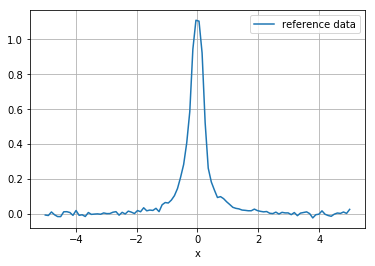

In [3]:
# Creation of reference data
lorentzian_noisy = QENSmodels.lorentzian(xx, 0.89, -0.025, 0.45)*(1+0.1*np.random.normal(0,1,100)) + 0.01*np.random.normal(0,1,100)
 
plt.plot(xx, lorentzian_noisy, label='reference data')

plt.xlabel('x')
plt.grid()
plt.legend()
plt.show()

In [4]:
# From https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html
# perform fit with initial guesses ScaleFactor=1, PeakCentre=0 FWHM=0.5
popt, pcov = curve_fit(QENSmodels.lorentzian, xx, lorentzian_noisy, p0=[1, 0, 0.5])
# Calculation of the errors on the refined parameters:
perr = np.sqrt(np.diag(pcov))
print 'Values of refined parameters:'
print 'ScaleFactor:', popt[0],'+/-', perr[0]
print 'PeakCentre :', popt[1],'+/-', perr[1]
print 'FWHM', popt[2],'+/-', perr[2]

Values of refined parameters:
ScaleFactor: 0.888167049388 +/- 0.0115046956413
PeakCentre : -0.0130579261122 +/- 0.00305109672826
FWHM 0.47140317704 +/- 0.00863840802156


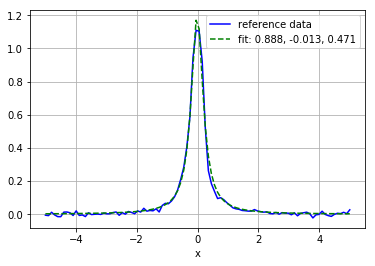

In [5]:
# Comparison of reference data with fitting result
plt.plot(xx, lorentzian_noisy, 'b-', label='reference data')
plt.plot(xx, QENSmodels.lorentzian(xx, *popt), 'g--', label='fit: %5.3f, %5.3f, %5.3f' % tuple(popt))
plt.legend()
plt.xlabel('x')
plt.grid()
plt.show()

## Example: simple fit  using lmfit
The following example uses the same data as in the main part of the document but the fitting is performed with [`lmfit`](https://lmfit.github.io/lmfit-py/) instead of `scipy.optimize.curve_fit`.

Names of parameters: ['scale_factor', 'peak_centre', 'fwhm']
Independent variable(s): ['x']
Result of fit:
[[Model]]
    Model(lorentzian)
[[Fit Statistics]]
    # function evals   = 23
    # data points      = 100
    # variables        = 3
    chi-square         = 0.054
    reduced chi-square = 0.001
    Akaike info crit   = -746.020
    Bayesian info crit = -738.204
[[Variables]]
    scale_factor:   0.90991396 +/- 0.012664 (1.39%) (init= 1)
    peak_centre:   -0.04509873 +/- 0.003151 (6.99%) (init= 0)
    fwhm:           0.45248224 +/- 0.008900 (1.97%) (init= 0.5)
[[Correlations]] (unreported correlations are <  0.100)
    C(scale_factor, fwhm)        =  0.707 



(<matplotlib.figure.Figure at 0x110a81610>,
 <matplotlib.gridspec.GridSpec at 0x110a81dd0>)

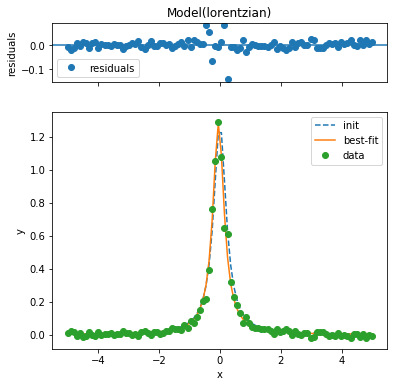

In [6]:
from lmfit import Model
import matplotlib.pyplot as plt
%matplotlib inline

gmodel = Model(QENSmodels.lorentzian)
print 'Names of parameters:', gmodel.param_names 
print 'Independent variable(s):', gmodel.independent_vars 

# Create array of reference data
xx = np.linspace(-5,5,100)
lorentzian_noisy = QENSmodels.lorentzian(xx, 0.89, -0.025, 0.45)*(1+0.1*np.random.normal(0,1,100)) + 0.01*np.random.normal(0,1,100)

# Fit
result = gmodel.fit(lorentzian_noisy, x=xx, scale_factor=1, peak_centre=0, fwhm=0.5)

# display result
print'Result of fit:\n',result.fit_report()

# plot
result.plot()

## Example: fit using two lorentzians convoluted with the instrument resolution and lmfit as the fitting engine

The following example uses the data from IRIS (workspace_index=0, file: `irs26176_graphite002_red.nxs` and the related instrument resolution data `irs26173_graphite002_res.nxs` from ISIS sample datasets that can be downloaded from http://download.mantidproject.org/).

These data are containing in the sample datafile: `data_2lorentzians.dat` and the instrument resolution datafile `irf_iris.dat`, respectively.

This example is based on a Mantid tutorial that can be found at https://www.mantidproject.org/Fitting_QENS_Peaks.

The implementation with `lmfit` is based on https://lmfit.github.io/lmfit-py/model.html

This example requires an additional Python module `scipy.interpolate` to interpolate the tabulated data of the instrument resolution

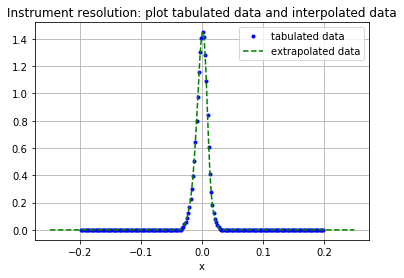

Names of parameters: ['amp1', 'centre1', 'fwhm1', 'amp2', 'centre2', 'fwhm2']
Independent variable(s): ['x']
Result of fit:
[[Model]]
    (Model(irf_gate) <function convolve at 0x10e6051b8> Model(model_2lorentzians))
[[Fit Statistics]]
    # function evals   = 387
    # data points      = 1905
    # variables        = 6
    chi-square         = 0.681
    reduced chi-square = 0.000
    Akaike info crit   = -15105.623
    Bayesian info crit = -15072.310
[[Variables]]
    amp1:     -0.00246457 +/- 4.76e-06 (0.19%) (init= 1)
    centre1:  -0.12552369 +/- 3.32e-05 (0.03%) (init= 0)
    fwhm1:    -0.03281942 +/- 0.000105 (0.32%) (init= 0.5)
    amp2:     -904.754710 +/- 1.41e+08 (15545723.57%) (init= 1)
    centre2:  -20756.4359 +/- 1.73e+07 (83301.59%) (init= 1)
    fwhm2:    -1362.68966 +/- 2.10e+08 (15418915.01%) (init= 0.5)
[[Correlations]] (unreported correlations are <  0.100)
    C(amp2, fwhm2)               = -1.000 
    C(amp1, fwhm1)               =  0.773 
    C(amp2, centre2)    

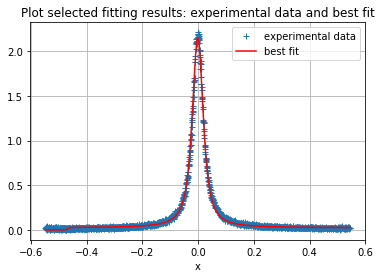

(<matplotlib.figure.Figure at 0x110ba6910>,
 <matplotlib.gridspec.GridSpec at 0x110d73a90>)

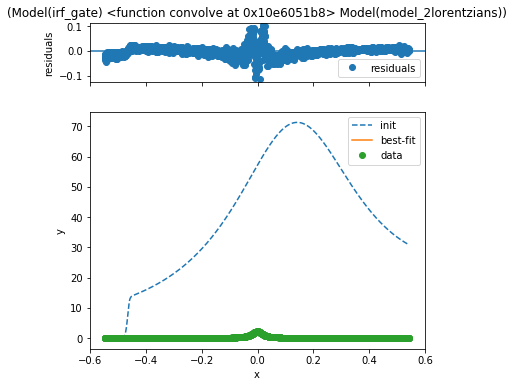

In [7]:
from lmfit import Model, CompositeModel
from scipy.interpolate import interp1d

# Create model - 2 lorentzians convoluted with instrument resolution - 6 parameters
# Step 1 load instrument resolution data
irf_iris = np.loadtxt('irf_iris.dat')
x_irf = irf_iris[:, 0]
y_irf = irf_iris[:, 1]

# Step 2: create function for instrument resolution data (cubic interpolation between tabulated data points)
f=interp1d(x_irf, y_irf, kind='cubic', bounds_error=False, fill_value='extrapolate')

def irf_gate(x):
    " Create function from interpolated data that can be used with lmfit "
    return f(x)

# plot tabulated data and interpolated data
xx = np.linspace(-.25,.25,500)
plt.plot(x_irf, y_irf, 'b.', label='tabulated data')
plt.plot(xx, irf_gate(xx), 'g--', label='extrapolated data')
plt.legend()
plt.xlabel('x')
plt.title('Instrument resolution: plot tabulated data and interpolated data')
plt.grid()
plt.show()

# Step 3: create "double lorentzian" profile
def model_2lorentzians(x, amp1, centre1, fwhm1, amp2, centre2, fwhm2):
    return QENSmodels.lorentzian(x, amp1, centre1, fwhm1) + QENSmodels.lorentzian(x, amp2, centre2, fwhm2)

# Step 4: create convolution function 
# (code from https://lmfit.github.io/lmfit-py/model.html)
def convolve(arr, kernel):
    # simple convolution of two arrays
    npts = min(len(arr), len(kernel))
    pad  = np.ones(npts)
    tmp  = np.concatenate((pad*arr[0], arr, pad*arr[-1]))
    
    out  = np.convolve(tmp, kernel, mode='valid')
    noff = int((len(out) - npts)/2)
    return out[noff:noff+npts]

# Create model for the fit
gmodel = CompositeModel(Model(irf_gate), Model(model_2lorentzians), convolve) 

print 'Names of parameters:', gmodel.param_names 
print 'Independent variable(s):', gmodel.independent_vars 

# Load reference data - extract x and y values
two_lorentzians_iris = np.loadtxt('data_2lorentzians.dat')
xx = two_lorentzians_iris[:, 0]
yy = two_lorentzians_iris[:, 1]

# Fit
result = gmodel.fit(yy, x=xx, amp1=1, centre1=0, fwhm1=0.5, amp2=1, centre2=1, fwhm2=0.5)

# display result
print'Result of fit:\n',result.fit_report()


# plot selected results: experimental data and best fit
plt.plot(xx, yy, '+', label='experimental data')

plt.plot(xx, result.best_fit, 'r-', label='best fit')
plt.grid()
plt.xlabel('x')
plt.title('Plot selected fitting results: experimental data and best fit')
plt.legend()
plt.show()

# plot result
result.plot()